# Testing the optimization submodule for 1 dof elements (bars), 1D geometries

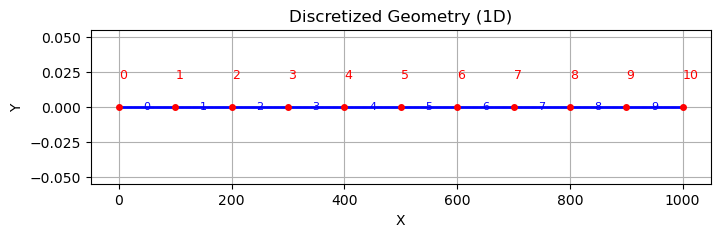

Constraint check passed: 1 DOFs constrained out of 11.


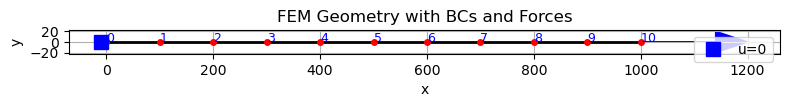

In [1]:
import fem_toolbox as ft

# read geometry

nodes_coords_beam, beam_connectivity, beam_crossSections, mat_properties = ft.geometry.read_structure("../shape_optimization/geom/myrod.txt")

# meshing
elements_per_beam = 10

fem_nodes, fem_elements, element_crossSections = ft.mesh.discretize(nodes_coords_beam, beam_connectivity, beam_crossSections, elements_per_beam=elements_per_beam)

ft.mesh.plot_discretized_geometry_1D(nodes_coords_beam, beam_connectivity, fem_nodes, fem_elements)

ndof_per_node = 1

# BC and forces
_ , bc_nodes, bc_dofs, bc_values, f_nodes, f_dofs, f_values = ft.BC_loads.read_bc_and_forces("../shape_optimization/geom/myrodBC.txt")

# validate constraints (read docs)
num_nodes= fem_nodes.shape[0]
ft.BC_loads.validate_constraints(num_nodes, ndof_per_node, bc_nodes, bc_dofs)

# visual validation before solving 
ft.BC_loads.plot_fem_model(fem_nodes, fem_elements, bc_nodes, bc_dofs, bc_values, f_nodes, f_dofs, f_values, scale_force=0.2)


In [2]:
# assemble global mass matrix rod
local_m_matrix = ft.elements.m_rod
local_k_matrix = ft.elements.k_rod
rotation_matrix = None 

M_global = ft.femsolver.assembleM(local_m_matrix, rotation_matrix, fem_nodes, fem_elements, element_crossSections, mat_properties, ndof_per_node)

K_global = ft.femsolver.assembleK(local_k_matrix, rotation_matrix, fem_nodes, fem_elements, element_crossSections, mat_properties, ndof_per_node)

# assemble global force vector
num_dofs = M_global.shape[0]
f_ext = ft.femsolver.build_force_vector(f_nodes, f_dofs, f_values, num_dofs, ndof_per_node)

# Modal analysis
print(f"\nBoundary conditions: {bc_dofs}\n")

frequencies, mode_shapes, free_dofs = ft.femsolver.modal_analysis(K_global, M_global, bc_nodes, bc_dofs, ndof_per_node, num_modes = 3, verbose=True)

# static analysis (for checking purposes)
u = ft.femsolver.static_analysis(K_global, f_ext, bc_nodes, bc_dofs, bc_values, ndof_per_node)

print(f"\nNodal displacements: {u}")

# post processing stresses
cross_section = "circular"

stress_max, stress_axial, stress_bending, stress_shear, von_mises_stress, internal_actions = ft.postprocessing.eval_stress(ft.elements.k_rod, None, u,fem_elements, fem_nodes, element_crossSections, mat_properties, cross_section, ndof_per_node=1)

print(stress_axial)


Boundary conditions: [0]

Mode 1: 40.93 Hz
Mode 2: 123.81 Hz
Mode 3: 209.74 Hz

Nodal displacements: [0.         0.00146972 0.00293945 0.00440917 0.00587889 0.00734862
 0.00881834 0.01028807 0.01175779 0.01322751 0.01469724]
[3.08641975 3.08641975 3.08641975 3.08641975 3.08641975 3.08641975
 3.08641975 3.08641975 3.08641975 3.08641975]


## Optimization 1: 
**OBJECTIVE: weight minimization**

**CONSTRAINTS: stresses**

In [3]:
sigma_max = 20

# optimize
optim_areas_stress = ft.optimizer.optimize_crossSections4stress_1D(element_crossSections, sigma_max, fem_nodes, fem_elements, mat_properties, ndof_per_node, bc_nodes, bc_dofs, bc_values, f_nodes, f_dofs, f_values, ft.femsolver.assembleK, ft.femsolver.build_force_vector, local_k_matrix, None)


# check
ft.optimizer.checkOptimization_stresses1D(element_crossSections, optim_areas_stress, sigma_max, fem_nodes, fem_elements, mat_properties, ndof_per_node, bc_nodes, bc_dofs, bc_values, f_ext, f_nodes, f_dofs, ft.femsolver.assembleK, ft.femsolver.build_force_vector, local_k_matrix)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 499.9999999991338
            Iterations: 14
            Function evaluations: 157
            Gradient evaluations: 14
Element  | Area (orig) | Area (opt) | Stress (orig) | Stress (opt) | max_stress
---------|-------------|------------|----------------|----------------|----------
   0     |   324.00    |   50.00    |      3.09      |     20.00      |     20.00
   1     |   324.00    |   50.00    |      3.09      |     20.00      |     20.00
   2     |   324.00    |   50.00    |      3.09      |     20.00      |     20.00
   3     |   324.00    |   50.00    |      3.09      |     20.00      |     20.00
   4     |   324.00    |   50.00    |      3.09      |     20.00      |     20.00
   5     |   324.00    |   50.00    |      3.09      |     20.00      |     20.00
   6     |   324.00    |   50.00    |      3.09      |     20.00      |     20.00
   7     |   324.00    |   50.00    |      3.09      |

## Optimization 2 
**OBJECTIVE: weight minimization**

**CONSTRAINTS: forbidden frequency band**

Not always the optimizer converges to a good solution. If **optimizer exit mode is not 0**, please run again the function. 

Also if there are big area differences between consecutive elements (the optimization procedure penalizes such cases, but they can still happen), run again the function

In [7]:
forbidden_frequency_band = (35, 60)     # Hz

optim_areas_freq = ft.optimizer.optimize_crossSections4frequency_1D(element_crossSections, forbidden_frequency_band, fem_nodes, fem_elements, mat_properties, ndof_per_node, bc_nodes, bc_dofs, bc_values, ft.femsolver.assembleK, ft.femsolver.assembleM, 4, ft.elements.k_rod, ft.elements.m_rod, None, A_min = 50, A_max=400)

# check
ft.optimizer.checkOptimization_frequencies1D(
    element_crossSections,
    optim_areas_freq,
    forbidden_frequency_band,
    fem_nodes,
    fem_elements,
    mat_properties,
    ndof_per_node=1,
    bc_nodes=bc_nodes,
    bc_dofs=bc_dofs,
    assembleK=ft.femsolver.assembleK,
    assembleM=ft.femsolver.assembleM,
    k_local_func=ft.elements.k_rod,
    m_local_func=ft.elements.m_rod,
    num_modes=5,
    verbose=True,
)





[380.88359865 352.90268083 331.15323583 349.55344201 268.01231503
 295.73797776 369.95905192 368.31688548 354.56423185 372.84623303]
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1378.0712033980699
            Iterations: 667
            Function evaluations: 9765
            Gradient evaluations: 665

Element-wise Area Comparison:
Element | Area (original) | Area (optimized)
--------|------------------|------------------
   0     |      324.00      |      125.91     
   1     |      324.00      |      63.42      
   2     |      324.00      |      64.26      
   3     |      324.00      |      51.00      
   4     |      324.00      |      51.00      
   5     |      324.00      |      119.14     
   6     |      324.00      |      122.96     
   7     |      324.00      |      81.21      
   8     |      324.00      |      88.49      
   9     |      324.00      |      161.67     

Forbidden frequency band
    f_min = 35
    f_max = 60


Mo

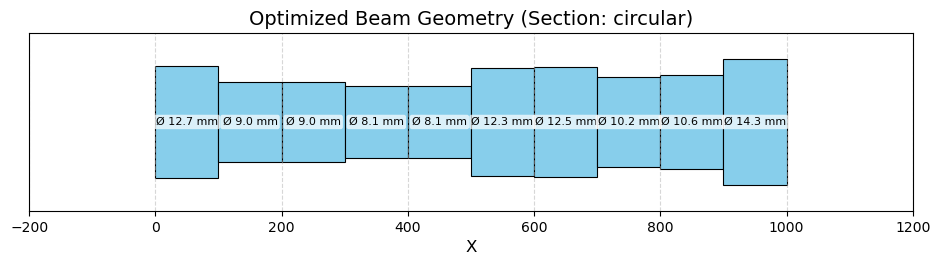

In [8]:
ft.optimizer.optim_plot_1D_beam_geometry(
    fem_nodes,
    fem_elements,
    optim_areas_freq,
    section_shape="circular",  # or "rectangle"
    show_labels=True
)
